# Lab. 8: Multi-Objective Optimization

## Introduction

#### <u>The goal of this lab is to study different Multi-Objective Optimization approaches.</u>

For this problem, we will use two problems as benchmarks:
1. Kursawe's function:
$\underset{x}{min}\begin{cases}f_1(x) &= \sum_{i=1}^{n-1} \left[-10e^{-0.2\sqrt{x_i^2 + x_{i+1}^2}}\right] \\ f_2(x) &= \sum_{i=1}^n \left[|x_i|^{0.8} + 5\sin(x_i)^3\right] \\\end{cases}$ s.t. $x_i \in [-5, 5]; i \in [1,n]$
2. Multiple-disk clutch brake optimization: This real world optimization problem consists in the optimization of 5 paramters concernining multiple-disk clutch brakes. The parameters are shown visually in the image below.
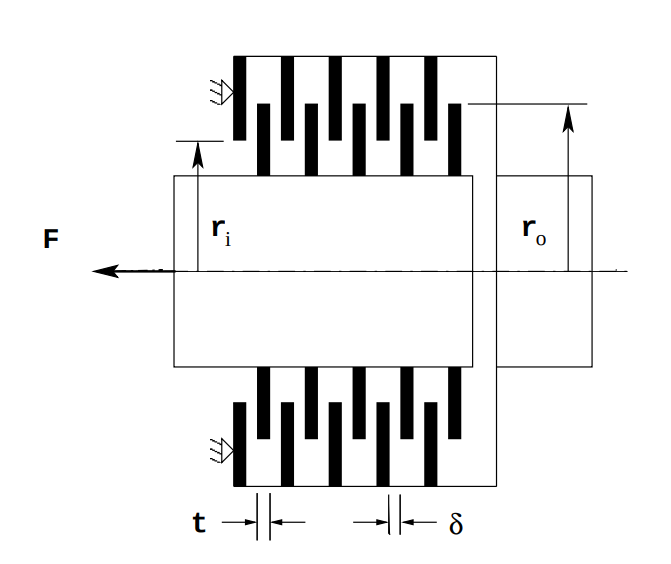

(Image taken from Deb and Srinivasan, "Innovization: Innovative Design Principles Through Optimization")

Two conflicting objectives are considered in the problem of this exercise:
1. minimization of break system mass(in kg)
2. minimization of stopping time(in s).

This problem is characterzied by five decision variables that are:
1. $r_i$ the inner radius in mm. $r_i = (60, 61, 62, . . . , 78, 79, 80)mm$
2. $r_o$ the outer radius in . $r_o = (90, 91, 92, . . . , 108, 109, 110)mm$
3. $t$ the tickness of discs in mm. $t = (1, 1.5, 2, 2.5, 3)mm$
4. $F$ the actuating force in N(Newton). $F = (600, 610, 620, . . . , 980, 990, 1000)N$
5. $Z$ the number of discs. $Z = (2, 3, 4, 5, 6, 7, 8, 10)$

**For each of the exercises, perform multiple runs (with different random seeds) to reduce the effect of randomness on the results.**

### Helper functions

In [19]:
%%capture
!pip install inspyred

In [20]:
import copy
import functools
from pylab import *
from inspyred import benchmarks
import inspyred
from inspyred.ec.emo import Pareto
from numpy.random import RandomState
from inspyred.ec.variators import mutator
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import terminators, variators, replacers, selectors

In [21]:
#@markdown Implementation of benchmarks and utilites (double click to open)

def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)

        return asarray([population[i] for i in
                        choice_without_replacement(self, len(population), k)])
        #return #self.choice(population, k, replace=False)

    def random(self):
        return self.random_sample()

    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)

def initial_pop_observer(population, num_generations, num_evaluations,
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate
                                                 for guy in population])
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness
                                          for guy in population])

def generator(random, args):
    return asarray([random.uniform(args["pop_init_range"][0],
                                   args["pop_init_range"][1])
                    for _ in range(args["num_vars"])])

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return asarray(func(random, args))
        return _generator

class CombinedObjectives(Pareto):
    def __init__(self, pareto, args):

        
        """ edit this function to change the way that multiple objectives
        are combined into a single objective

        """

        Pareto.__init__(self, pareto.values)
        if "fitness_weights" in args :
            weights = asarray(args["fitness_weights"])
        else :
            weights = asarray([1 for _ in pareto.values])

        self.fitness = sum(asarray(pareto.values) * weights)

    def __lt__(self, other):
        return self.fitness < other.fitness

def single_objective_evaluator(candidates, args):
    problem = args["problem"]
    return [CombinedObjectives(fit,args) for fit in
            problem.evaluator(candidates, args)]

# parameters, see Deb 2006
Delta_R = 20 # mm
L_max = 30 # mm
delta = 0.5 # mm
p_max = 1 # MPa
V_sr_max = 10 # m/s
n = 250 # rpm
mu = 0.5
s = 1.5
M_s = 40 # Nm
omega = pi * n/30. # rad/s
rho = 0.0000078 # kg/mm^3
T_max = 15 # s
M_f = 3 # Nm
I_z = 55 # kg*m^2

#possible values
values = [arange(60,81,1), arange(90,111,1), arange(1.5,3.5, 0.5),
          arange(600,1010,10), arange(2,10,1)]


class DiskClutchBounder(object):
    def __call__(self, candidate, args):
        closest = lambda target, index: min(values[index],
                                            key=lambda x: abs(x-target))
        for i, c in enumerate(candidate):
            candidate[i] = closest(c,i)
        return candidate

class ConstrainedPareto(Pareto):
    def __init__(self, values=None, violations=None, ec_maximize=True):
        Pareto.__init__(self, values)
        self.violations = violations
        self.ec_maximize=ec_maximize

    def __lt__(self, other):
        if self.violations is None :
            return Pareto.__lt__(self, other)
        elif len(self.values) != len(other.values):
            raise NotImplementedError
        else:
            if self.violations > other.violations :
                # if self has more violations than other
                # return true if EC is maximizing otherwise false
                return (self.ec_maximize)
            elif other.violations > self.violations :
                # if other has more violations than self
                # return true if EC is minimizing otherwise false
                return (not self.ec_maximize)
            elif self.violations > 0 :
                # if both equally infeasible (> 0) than cannot compare
                return False
            else :
                # only consider regular dominance if both are feasible
                not_worse = True
                strictly_better = False
                for x, y, m in zip(self.values, other.values, self.maximize):
                    if m:
                        if x > y:
                            not_worse = False
                        elif y > x:
                            strictly_better = True
                    else:
                        if x < y:
                            not_worse = False
                        elif y < x:
                            strictly_better = True
            return not_worse and strictly_better

class DiskClutchBrake(benchmarks.Benchmark):

    def __init__(self, constrained=False) :
        benchmarks.Benchmark.__init__(self, 5, 2)
        self.bounder = DiskClutchBounder()
        self.maximize = False
        self.constrained=constrained

    def generator(self, random, args):
        return [random.sample(values[i],1)[0] for i in range(self.dimensions)]

    def evaluator(self, candidates, args):
        fitness = []
        for c in candidates:
            f1 = pi * (c[1] ** 2 - c[0] ** 2) * c[2] * (c[4] + 1) * rho

            M_h = ( (2./3.) * mu * c[3] * c[4]  *
                (c[1] ** 3 - c[0] ** 3) /
                (c[1] ** 2 - c[0] ** 2) ) / 1000. # N*m
            T = (I_z * omega) / (M_h + M_f)

            f2 = T

            fitness.append(ConstrainedPareto([f1, f2],
                                             self.constraint_function(c),
                                             self.maximize))

        return fitness

    def constraint_function(self,candidate):
        if not self.constrained :
            return 0
        """Return the magnitude of constraint violations."""
        A = pi * (candidate[1] ** 2 - candidate[0] ** 2) # mm^2
        p_rz = candidate[3]/A # N/mm^2
        R_sr = ( (2./3.) * (candidate[1] ** 3 - candidate[0] ** 3) /
                 (candidate[1] ** 2 - candidate[0] ** 2) )  # mm
        V_sr = pi * R_sr * n / 30000. # m/s

        M_h = ( (2./3.) * mu * candidate[3] * candidate[4]  *
                (candidate[1] ** 3 - candidate[0] ** 3) /
                (candidate[1] ** 2 - candidate[0] ** 2) ) / 1000. # N*m

        T = (I_z * omega) / (M_h + M_f)

        violations = 0
        #g_1
        if (candidate[1] - candidate[0] - Delta_R) < 0 :
            violations -= (candidate[1] - candidate[0] - Delta_R)
        #g_2
        if (L_max - (candidate[4] + 1)*(candidate[2] + delta)) < 0 :
            violations -= (L_max - (candidate[4] + 1)*(candidate[2] + delta))
        #g_3
        if (p_max - p_rz) < 0 :
            violations -= (p_max - p_rz)
        #g_4
        if (p_max*V_sr_max - p_rz * V_sr) < 0 :
            violations -= (p_max*V_sr_max - p_rz * V_sr)
        #g_5
        if (V_sr_max - V_sr) < 0 :
            violations -= (V_sr_max - V_sr)
        #g_6
        if ( M_h - s * M_s) < 0 :
            violations -= ( M_h - s * M_s)
        #g_7
        if ( T < 0 ) :
            violations -= T
        #g_8
        if  (T_max - T) < 0 :
            violations -= (T_max - T)

        return violations

@mutator
def disk_clutch_brake_mutation(random, candidate, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    bounder = args['_ec'].bounder
    mutant = copy(candidate)
    for i, m in enumerate(mutant):
        if random.random() < mut_rate:
            mutant[i] += random.gauss(0, (values[i][-1] - values[i][0]) / 10.0 )
    mutant = bounder(mutant, args)
    return mutant

import math

class NSGA2(inspyred.ec.emo.NSGA2):
    # helper function used to store the various populations at each generation
    def _best_archiver(self, random, population, archive, args):
        self.population_archive.append(population)
        new_archive = archive
        for ind in population:
            if len(new_archive) == 0:
                new_archive.append(ind)
            else:
                should_remove = []
                should_add = True
                for a in new_archive:
                    if (np.array(ind.candidate) == np.array(a.candidate)).all():
                        should_add = False
                        break
                    elif ind < a:
                        should_add = False
                    elif ind > a:
                        should_remove.append(a)
                for r in should_remove:
                    new_archive.remove(r)
                if should_add:
                    new_archive.append(ind)
        return new_archive

def run_nsga2(random, problem, display=False, num_vars=0, use_bounder=True,
        variator=None, **kwargs) :
    """ run NSGA2 on the given problem """
    kwargs=kwargs['kwargs']
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = NSGA2(random)
    algorithm.population_archive = []
    algorithm.archiver = algorithm._best_archiver
    algorithm.terminator = terminators.generation_termination
    if variator is None :
        algorithm.variator = [variators.blend_crossover,
                              variators.gaussian_mutation]
    else :
        algorithm.variator = variator

    kwargs["num_selected"]=kwargs["pop_size"]
    if use_bounder :
        kwargs["bounder"]=problem.bounder

    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator
    final_pop = algorithm.evolve(evaluator=problem.evaluator,
                          maximize=problem.maximize,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)

    all_populations = algorithm.population_archive
    for i in range(len(all_populations)):
        all_populations[i] = np.array([elem.fitness for elem in all_populations[i]])

    best_guy = final_pop[0].candidate[0:num_vars]
    best_fitness = final_pop[0].fitness
    #final_pop_fitnesses = asarray([guy.fitness for guy in algorithm.archive])
    #final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in algorithm.archive])
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in final_pop])

    return final_pop_candidates, final_pop_fitnesses, all_populations, best_fitness, best_guy

def run_ga(random,problem, display=False, num_vars=0,
           maximize=False, use_bounder=True, **kwargs) :
    """ run a GA on the given problem """
    kwargs=kwargs['kwargs']
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = EvolutionaryComputation(random)
    algorithm.terminator = terminators.generation_termination
    algorithm.replacer = replacers.generational_replacement
    algorithm.variator = [variators.uniform_crossover,
                          variators.gaussian_mutation]
    algorithm.selector = selectors.tournament_selection
    algorithm.observer = [initial_pop_observer]

    kwargs["num_selected"]=kwargs["pop_size"]
    if use_bounder :
        kwargs["bounder"]=problem.bounder
    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator

    kwargs["problem"] = problem
    final_pop = algorithm.evolve(evaluator=single_objective_evaluator,
                                 maximize=problem.maximize,
                                 initial_pop_storage=initial_pop_storage,
                                 num_vars=num_vars,
                                 **kwargs)

    best_guy = final_pop[0].candidate

    best_fitness = final_pop[0].fitness.fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    return best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates

def plot_pareto(final_pop_fitnesses, function_labels=None):
    plt.scatter(final_pop_fitnesses.T[0], final_pop_fitnesses.T[1], color="red", label="Pareto front")

    if not function_labels:
        plt.xlabel("f1")
        plt.ylabel("f2")
    else:
        plt.xlabel(function_labels[0])
        plt.ylabel(function_labels[1])

    plt.legend(loc="upper right")
    plt.legend()
    plt.show()

def plot_pareto_rank(all_populations, function_labels=None):
    fig, ax = plt.subplots(1,1)
    fig.set_figwidth(10)
    fig.set_figheight(7)

    pareto_front = all_populations[-1]
    ax.scatter(pareto_front.T[0], pareto_front.T[1], color="red", label="Pareto front")

    for i in range(min(len(all_populations), 5)):
        ax.scatter(all_populations[i].T[0], all_populations[i].T[1], label=("Front " + str(i+1)))

    if not function_labels:
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
    else:
        ax.set_xlabel(function_labels[0])
        ax.set_ylabel(function_labels[1])
    plt.legend(loc="upper right")
    plt.legend()
    plt.show()

### Exercises

#### Exercise 1/2: Kursawe's function

1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?

Different weights assign different importance to the optimization functions, consequently leading to a prior selection of which objective is more important.
It's evident that adjusting the weights has a profound effect on the search outcomes, in particular increasing the weight of one objective tends to optimize that objective at the expense of the other, while when weights are balanced, the results tend to be more evenly optimized between objectives.
The solution i sstrictly related to the weights

2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.


The Pareto frontier, obtained through the use of NSGA-II, identifies those solutions that are not dominated by any other point in the goal space. In other words, each solution on the Pareto frontier represents a compromise such that no objective can be improved without worsening at least one other. These solutions are therefore considered to be equivalently optimal within the specific context of the problem. After determining which points are on the Pareto frontier, one enters the decision-making phase, where one must choose the solution that best satisfies the specific priorities or needs.
The presence of holes or discontinuities in the Pareto frontier suggests that the frontier is non-convex, indicating that the optimisation problem is complex and that the interaction between the objectives may generate non-linear trade-off regions.


3. Compare the weighted-sum method with NSGA-II

The presence of holes in the Pareto frontier suggests that it is non-convex, which implies that some optimal solutions cannot be achieved by a simple linear combination of the objective functions. Consequently, the Pareto front may be better.
In the weighted sum method, the weights of the objective functions are chosen a priori, which means that the relative importance of each objective is established in advance. This approach can be quicker and more straightforward, especially when prior knowledge of objective priorities is available, making it effective for problems where the hierarchy of needs is clear and well defined.
On the other hand, NSGA-II does not require a priori decisions regarding the weight of the objectives. This algorithm generates a variety of solutions that form the Pareto frontier, offering a set of optimal options to choose from a posteriori. This allows for greater flexibility and a more informed choice based on visualising the trade-offs between different solutions.
Although the weighted sum method may be faster due to its computational simplicity, NSGA-II offers the advantage of exploring the solution space more extensively, being particularly useful in complex scenarios where interactions between objectives are less predictable and more intricate




PESI: 	 [0.1, 0.9]
best_guy: [-1.5168177173262212, -1.516743485309235, -1.5223414025449342],	 best_fitness (combianta): -10.975044001775323
valori delle singole fitness: [[-13.017974578086577, -10.748051715518518]]
minimo: -10.974736320253642 +- 0.001106821617531282
--------------------------------------------------------------------------------------------------------------------------------




PESI: 	 [0.3, 0.7]
best_guy: [-1.4956816967567523, -1.460938767665343, -1.520405281510196],	 best_fitness (combianta): -11.444087676077347
valori delle singole fitness: [[-13.141826246377088, -10.716485431663173]]
minimo: -11.44620207369713 +- 0.0014495149222718007
--------------------------------------------------------------------------------------------------------------------------------




PESI: 	 [0.5, 0.5]
best_guy: [-1.4569541502821628, -1.395693174518258, -1.4601957394749339],	 best_fitness (combianta): -11.966022958701386
valori delle singole fitness: [[-13.356188349089575, -10.575

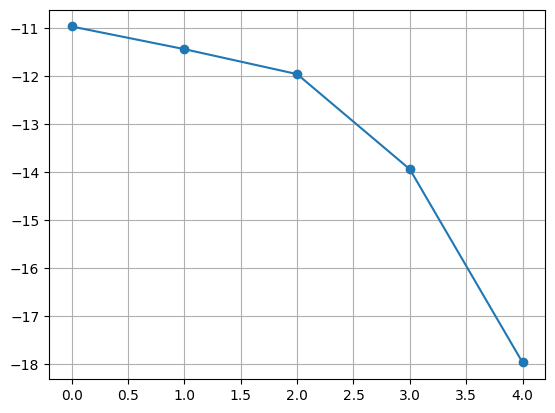

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import random
# Instantiate the problem
problem = benchmarks.Kursawe(3)

# Parameters for the GA
args = {}
args["pop_size"] = 50
args["max_generations"] = 100
weights = [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]


mean_vec = []
for fitness_weight in weights:
    args['fitness_weights'] = fitness_weight
    min_list = []
    for sssss in range(100):
        rng = NumpyRandomWrapper(random.randint(0,10))  # Initialize a random number generator with a seed
        best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates = run_ga(rng, problem, kwargs=args)
            
        if sssss == 0:
            print("\nPESI: \t", fitness_weight)
            print(f'best_guy: {best_guy},\t best_fitness (combianta): {best_fitness}')
            print('valori delle singole fitness:',problem.evaluator([best_guy], args))

        min_list.append(best_fitness)
        
    media = np.mean(min_list)
    mean_vec.append(media)
    varianza = np.std(min_list)
    print(f'minimo: {media} +- {varianza}' )
    print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')

plt.plot(mean_vec, marker='o')
plt.grid(True)
plt.show()

best_guy: [], 	 best_fitness: [-13.06072744993527, -10.607998972914189]


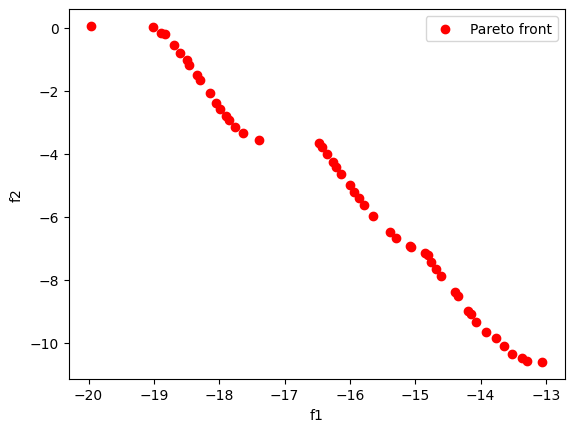

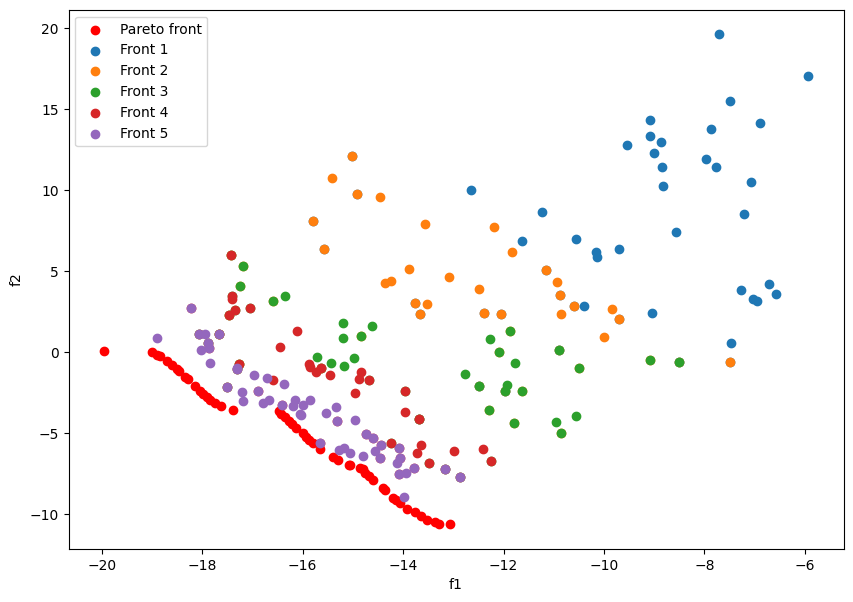

In [28]:
# Instantiate the problem
problem = benchmarks.Kursawe(3)

# Parameters for the GA
args = {}
args["pop_size"] = 50
args["max_generations"] = 100

rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
final_pop_candidates, final_pop_fitnesses, all_populations, best_fitness, best_guy = run_nsga2(rng, problem, kwargs=args)
print(f"best_guy: {best_guy}, \t best_fitness: {best_fitness}")

plot_pareto(final_pop_fitnesses, function_labels=None)
plot_pareto_rank(all_populations, function_labels=None)

#### Exercise 2/2: Multi-disk clutch brake optimization

1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?

Different weights assign different importance to the optimization functions, consequently leading to a prior selection of which objective is more important.
It's evident that adjusting the weights has a profound effect on the search outcomes, in particular increasing the weight of one objective tends to optimize that objective at the expense of the other, while when weights are balanced, the results tend to be more evenly optimized between objectives.
The solution i sstrictly related to the weights.
Additionally, it can be noted that as the weights change, the values of the first three parameters and the last one remain stable; what particularly varies is the value of the fourth parameter.

2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.

Ideal Pareto fronts should have a uniform density, covering all possible trade-offs evenly. Is it possible to notice that without constraints there is a crowding problem; solutions are clustered too close to each other along the Pareto front. f the Pareto front is crowded in certain areas, it restricts the variety of choices available, potentially omitting other valuable solutions that could be more suitable under different considerations or preferences, so it limites the power of the decision-making process. 

3. Compare the weighted-sum method with NSGA-II


PESI = [0.1, 0.9], 	 PARAMS = True
best_guy: [80, 110, 1.5, 930, 9],	 best_fitness (combianta): 3.4181647580466885
valori delle singole fitness: [[-2.7991115485055972e-09, 320.8771474869674]]
minimo: 3.283362050390918 +- 0.09450953874816888
--------------------------------------------------------------------------------------------------------------------------------



PESI = [0.3, 0.7], 	 PARAMS = True
best_guy: [80, 90, 1.5, 980, 9],	 best_fitness (combianta): 2.8519438015215113
valori delle singole fitness: [[-1.5226692909050976e-07, 328.1879170131144]]
minimo: 2.851276932570568 +- 0.07533546381240762
--------------------------------------------------------------------------------------------------------------------------------



PESI = [0.5, 0.5], 	 PARAMS = True
best_guy: [80, 90, 1.5, 980, 9],	 best_fitness (combianta): 2.215634937886511
valori delle singole fitness: [[-1.5226692909050976e-07, 328.1879170131144]]
minimo: 2.2479655590046326 +- 0.0769524989580845
----------------

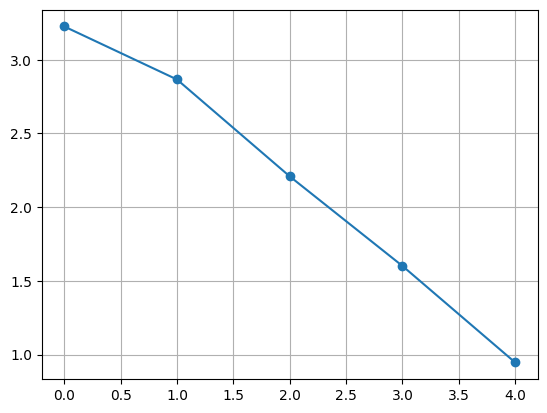

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import random
# Instantiate the problem
problem = benchmarks.Kursawe(3)
args = {}
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover,disk_clutch_brake_mutation]
weights = [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]




for param in [True, False]:
    problem2 = DiskClutchBrake(param)  # Initialize the problem
    mean_vec = []
    for fitness_weight in weights:
        args['fitness_weights'] = fitness_weight
        min_list = []
        
        for sssss in range(10):
            rng = NumpyRandomWrapper(random.randint(0,10))  # Initialize a random number generator with a seed
            best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates = run_ga(rng,problem2, kwargs=args)
            if sssss == 0:
                print(f"PESI = {fitness_weight}, \t VINCOLI = {param}")
                print(f'best_guy: {best_guy},\t best_fitness (combianta): {best_fitness}')
                print('valori delle singole fitness:',problem.evaluator([best_guy], args))

            min_list.append(best_fitness)
            
        media = np.mean(min_list)
        mean_vec.append(media)
        varianza = np.std(min_list)
        print(f'minimo: {media} +- {varianza}' )
        print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')

plt.plot(mean_vec, marker='o')
plt.grid(True)
plt.show()

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import random
# Instantiate the problem
problem = benchmarks.Kursawe(3)
args = {}
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover,disk_clutch_brake_mutation]
weights = [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]




for param in [True, False]:
    problem2 = DiskClutchBrake(param)  # Initialize the problem
    mean_vec = []
    for fitness_weight in weights:
        args['fitness_weights'] = fitness_weight
        min_list = []
        
        for sssss in range(5):
            rng = NumpyRandomWrapper(random.randint(0,10))  # Initialize a random number generator with a seed
            final_pop_candidates, final_pop_fitnesses, all_populations, best_fitness, best_guy = run_nsga2(rng, problem2, kwargs=args)
            if sssss == 0:
                print(f"best_guy: {best_guy}, \t best_fitness: {best_fitness}")
                plot_pareto(final_pop_fitnesses, function_labels=None)
                plot_pareto_rank(all_populations, function_labels=None)

            min_list.append(best_fitness)
            
        media = np.mean(min_list)
        mean_vec.append(media)
        varianza = np.std(min_list)
        print(f'minimo: {media} +- {varianza}' )
        print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')

plt.plot(mean_vec, marker='o')
plt.grid(True)
plt.show()

PESI = [0.1, 0.9], 	 VINCOLI = True
best_fitness (combianta): [0.4998902230392078, 11.43095300234448]
valori delle singole fitness: [[0, 0]]
minimo: 6.077938468615208 +- 5.6036736023336315
--------------------------------------------------------------------------------------------------------------------------------



PESI = [0.3, 0.7], 	 VINCOLI = True
best_fitness (combianta): [2.130782075704624, 3.3673578743831465]
valori delle singole fitness: [[0, 0]]
minimo: 4.644532137378951 +- 4.527891702281969
--------------------------------------------------------------------------------------------------------------------------------



PESI = [0.5, 0.5], 	 VINCOLI = True
best_fitness (combianta): [0.4822470386966476, 12.080361853418554]
valori delle singole fitness: [[0, 0]]
minimo: 5.430553632220737 +- 5.2125011664272165
--------------------------------------------------------------------------------------------------------------------------------



PESI = [0.7, 0.3], 	 VINCOLI = True
b

KeyboardInterrupt: 




VINCOLI:  True
best_guy: [], 	 best_fitness: [0.4704849158016074, 12.63344271020243]


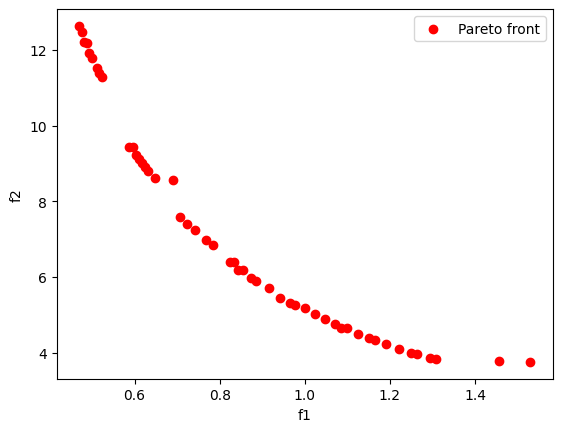

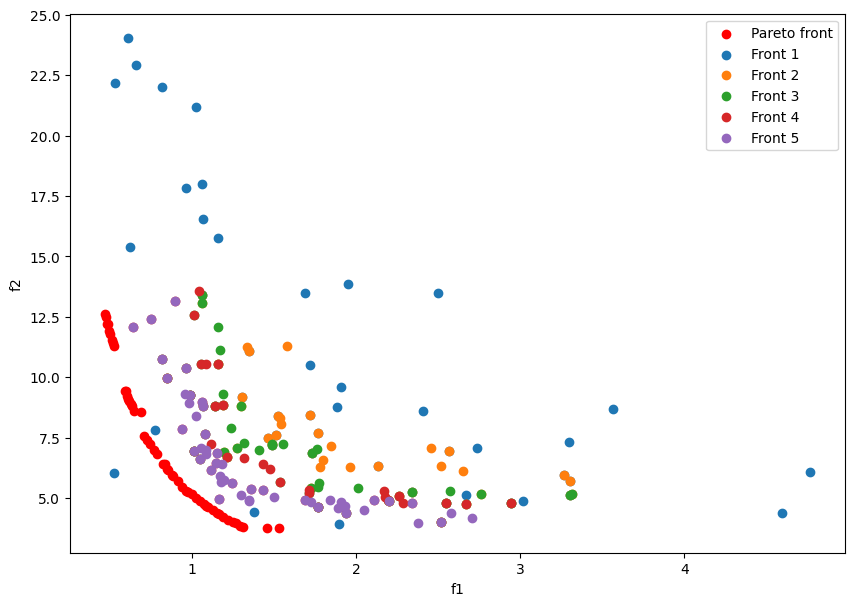




VINCOLI:  False
best_guy: [], 	 best_fitness: [0.18745883363970295, 16.344252899546277]


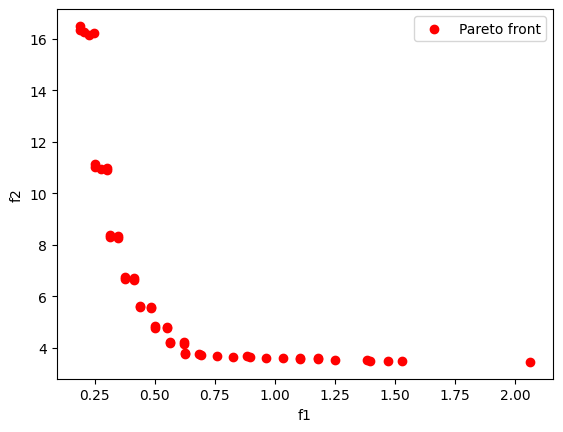

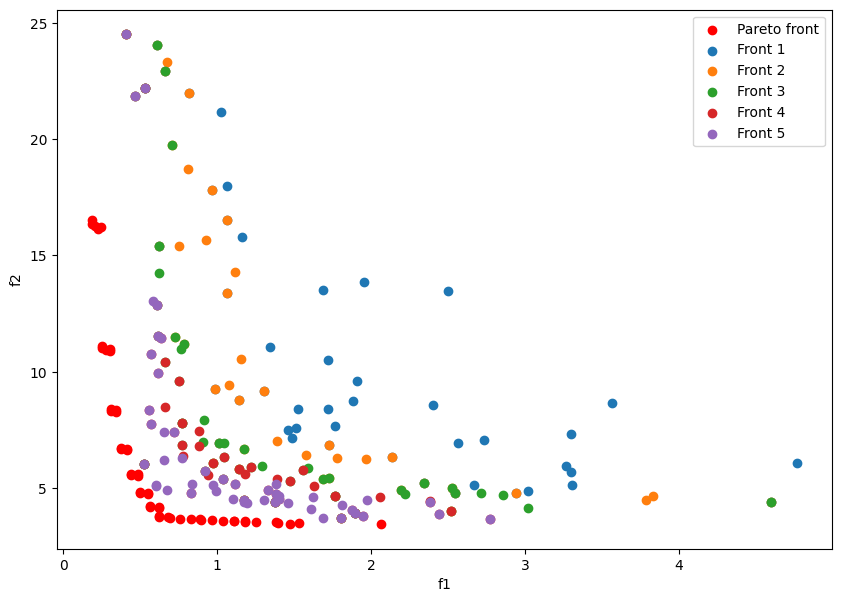

In [ ]:
# parameters for NSGA-2
args = {}
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover,disk_clutch_brake_mutation]

for param in [True, False]:
    print('\n\n\nVINCOLI: ',param)
    problem2 = DiskClutchBrake(param)  # Initialize the problem

    rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
    final_pop_candidates, final_pop_fitnesses, all_populations, best_fitness, best_guy = run_nsga2(rng, problem2, kwargs=args)
    print(f"best_guy: {best_guy}, \t best_fitness: {best_fitness}")

    plot_pareto(final_pop_fitnesses, function_labels=None)
    plot_pareto_rank(all_populations, function_labels=None)